# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
<!-- please do not append text into this block -->

# План

- *DONE* Перенести логику графиков сюда
- *DONE* Увеличить количество эпох
- `TODO` Сделать новые графики

## 1. Настройки

In [ ]:
# 1.1. Setup

REPORT_DIR = "report/"

TEST_SAMPLE_SIZE = 0.2
ITERATIONS = 10
RANDOM_STATE = 23432
BATCH_SIZE = 12
EPOCHS = 20
LEARNING_RATE = 0.00011
PP = [0, 0.01, 0.05, 0.5, 0.9, 0.95, 0.99]
PRINT_TRAINING_SPAN = 500

NOISE_SAMPLES_COUNT = 50
NOISE_FACTORS = [
    x * 2/NOISE_SAMPLES_COUNT for x in range(NOISE_SAMPLES_COUNT)
]

In [4]:
# 1.2. Pip dependencies

# pip install torch torchvision pandas scikit-learn 'numpy<2'

In [5]:
# 1.3. Enable CUDA

import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 2. Генерация отчёта

In [ ]:
# 2.1. Report generation

import os
import json

if not os.path.exists(REPORT_DIR):
    os.makedirs(REPORT_DIR)

report_data = {}

def append_to_report(label, data):
    report_data[label] = data

def save_report():
    path = os.path.join(REPORT_DIR, 'report.json')
    with open(path, 'w') as file:
        json.dump(report_data, file, indent=4)
    print(f"Отчёт сохранён в {path}")

## 3. Данные

In [7]:
# 3.1. Classification tasks

import torch
import torch.nn as nn
from dataclasses import dataclass

@dataclass
class LearningTask:
    criterion: object
    dtype: torch.dtype

CLASSIFICATION_TASK = LearningTask(
    criterion=nn.CrossEntropyLoss(),
    dtype=torch.long
)

REGRESSION_TASK = LearningTask(
    criterion=nn.MSELoss(),
    dtype=torch.float
)

In [8]:
# 3.2. Dataset utilities

from typing import List, Tuple

import urllib.request
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

def download_csv(
    url: str,
    saved_name: str,
    features: List[str] = None
) -> pd.DataFrame:
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)
    file_path = os.path.join(data_dir, saved_name)

    urllib.request.urlretrieve(url, file_path)

    if features is None:
        return pd.read_csv(file_path)
    else:
        return pd.read_csv(file_path, header=None, names=features)

def tensor_dataset_from_dataframe(
    df: pd.DataFrame,
    target: str,
    y_dtype: type
) -> TensorDataset:
    X = df.drop(columns=[target]).values
    y = df[target].values

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=y_dtype)

    return TensorDataset(X_tensor, y_tensor)

In [9]:
# 3.3 breast_cancer_dataset()

def breast_cancer_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/dataspelunking/MLwR/refs/heads/master/Machine%20Learning%20with%20R%20(2nd%20Ed.)/Chapter%2003/wisc_bc_data.csv',
        saved_name='wisc_bc_data.csv'
    )

    target = 'diagnosis'

    df[target] = df[target].map({ 'M': 0, 'B': 1 })
    df = df.drop(columns=['id'])

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        tensor_dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        ),
        tensor_dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        )
    )

In [10]:
# 3.4 car_evaluation_dataset()

def car_evaluation_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/mragpavank/car-evaluation-dataset/refs/heads/master/car_evaluation.csv',
        saved_name='car_evaluation.csv',
        features=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    )

    target = 'class'

    df[target] = df[target].map({
        'unacc': 0,
        'acc': 1,
        'good': 2,
        'vgood': 3,
    })

    df['doors'] = df['doors'].map({
        '2': 2,
        '3': 3,
        '4': 4,
        '5more': 5
    })

    high_map = {
        'low': 0,
        'med': 1,
        'high': 2,
        'vhigh': 3
    }

    df['buying'] = df['buying'].map(high_map)
    df['safety'] = df['safety'].map(high_map)
    df['maint'] = df['maint'].map(high_map)

    df['persons'] = df['persons'].map({
        '2': 2,
        '4': 4,
        'more': 6
    })

    df['lug_boot'] = df['lug_boot'].map({
        'small': 0,
        'med': 1,
        'big': 2
    })

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )
    return (
        tensor_dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        ),
        tensor_dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=CLASSIFICATION_TASK.dtype
        )
    )

In [11]:
# 3.5 student_performance_factors_dataset()

def student_performance_factors_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = pd.read_csv('data/StudentPerformanceFactors.csv')

    target = 'Exam_Score'

    lmh = {
        'Low': -1,
        'Medium': 0,
        'High': +1,
    }

    yn = {
        'Yes': +1,
        'No': -1,
    }

    df = df.dropna(subset=['Teacher_Quality'])

    df['Parental_Involvement'] = df['Parental_Involvement'].map(lmh)
    df['Access_to_Resources'] = df['Access_to_Resources'].map(lmh)
    df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(yn)
    df['Motivation_Level'] = df['Motivation_Level'].map(lmh)
    df['Internet_Access'] = df['Internet_Access'].map(yn)
    df['Family_Income'] = df['Family_Income'].map(lmh)
    df['Teacher_Quality'] = df['Teacher_Quality'].map(lmh)
    df['School_Type'] = df['School_Type'].map({
        'Public': +1,
        'Private': -1,
    })
    df['Peer_Influence'] = df['Peer_Influence'].map({
        'Positive': +1,
        'Neutral': 0,
        'Negative': -1,
    })
    df['Learning_Disabilities'] = df['Learning_Disabilities'].map(yn)
    df['Parental_Education_Level'] = df['Parental_Education_Level'].map({
        'Postgraduate': +3,
        'College': +2,
        'High School': +1,
    }).fillna(0)
    df['Distance_from_Home'] = df['Distance_from_Home'].map({
        'Near': +1,
        'Moderate': 0,
        'Far': -1,
    }).fillna(0)
    df['Gender'] = df['Gender'].map({
        'Female': +1,
        'Male': -1,
    }).fillna(0)

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        tensor_dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=REGRESSION_TASK.dtype
        ),
        tensor_dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=REGRESSION_TASK.dtype
        )
    )

In [12]:
# 3.6 Training related dataclasses

from dataclasses import dataclass

import pandas as pd
from torch.utils.data import DataLoader

@dataclass
class ExperimentParameters:
    iteration: int
    p: float

@dataclass
class DatasetData:
    train_dataset: pd.DataFrame
    test_dataset: pd.DataFrame
    train_loader: DataLoader
    test_loader: DataLoader

@dataclass
class Dataset:
    name: str
    number: int
    features_count: int
    classes_count: int
    data: DatasetData

    def model_a_path(self, params: ExperimentParameters) -> str:
        return f'report/model-{self.number}A-c-P{params.p}_N{params.iteration}.pth'

    def model_b_path(self, params: ExperimentParameters) -> str:
        return f'report/model-{self.number}B-c-P{params.p}_N{params.iteration}.pth'

In [13]:
# 3.7 Dataset factories

from torch.utils.data import DataLoader

def make_dataset1(batch_size: int) -> Dataset:
    train_dataset, test_dataset = breast_cancer_dataset()

    return Dataset(
        name='wisc_bc_data.csv',
        number=1,
        features_count=train_dataset[1][0].shape[0],
        classes_count=2,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset2(batch_size: int) -> Dataset:
    train_dataset, test_dataset = car_evaluation_dataset()

    return Dataset(
        name='car_evaluation.csv',
        number=2,
        features_count=train_dataset[1][0].shape[0],
        classes_count=4,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset3(batch_size: int) -> Dataset:
    train_dataset, test_dataset = student_performance_factors_dataset()

    return Dataset(
        name='StudentPerformanceFactors.csv',
        number=3,
        features_count=train_dataset[1][0].shape[0],
        classes_count=1,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

DATASETS = [
    make_dataset1(batch_size=12),
    make_dataset2(batch_size=12),
    make_dataset3(batch_size=12),
]


## 4. Модели

In [14]:
# 4.1. Custom layers

import torch

class CustomBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для линейного слоя.
    """
    @staticmethod
    def forward(
        ctx,
        p: float,
        input: torch.Tensor,
        weight: torch.Tensor,
        bias: float = None
    ):
        ctx.save_for_backward(torch.scalar_tensor(p), input, weight, bias)

        output = input.mm(weight.t())
        if bias is not None:
            output += bias

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input, weight, bias = ctx.saved_tensors

        height = weight.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
 
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        grad_output = grad_output.mm(diagonal_mask)

        grad_input = grad_output.mm(weight)
        grad_weight = grad_output.t().mm(input)

        if bias is not None:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return None, grad_input, grad_weight, grad_bias

class CustomReLUBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для слоя ReLU.
    """
    @staticmethod
    def forward(ctx, p: float, input: torch.Tensor):
        ctx.save_for_backward(torch.scalar_tensor(p), input)
        return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input = ctx.saved_tensors

        grad_output = grad_output * (input > 0).float()

        # У матриц ось 0 это Y
        height = grad_output.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        diagonal_mask = diagonal_mask.unsqueeze(1).expand(-1, grad_output.size(1), -1)
        diagonal_mask = diagonal_mask.permute(0, 2, 1)

        grad_output = grad_output.unsqueeze(1) * diagonal_mask
        grad_output = grad_output.sum(dim=1)

        return None, grad_output

    
class CustomReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, p: float):
        ctx.save_for_backward(input, torch.scalar_tensor(p))
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, p, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= 0] = 0

        # У матриц ось 0 это Y (Добавляем аргумент device=grad_output.device для указания устройства для создания тензора grad_input)
        bernoulli_mask = torch.bernoulli(torch.ones(grad_input.size(0), device=grad_output.device) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item()+1e-5)

        # Перемещаем diagonal_mask на Cuda
        diagonal_mask = diagonal_mask.to(grad_output.device)
        
        # Multiply grad_input with the diagonal matrix
        grad_input = diagonal_mask @ grad_input
        
        return grad_input, None
    
    
class CustomReLULayer(torch.nn.Module):
    def __init__(self, p: float):
        super(CustomReLULayer, self).__init__()
        self.p = p
        self.custom_relu_backward = CustomReLUFunction.apply

    def forward(self, x):
        return self.custom_relu_backward(x, self.p)

In [15]:
# 4.2. Neural networks

import torch.nn as nn
import torch.nn.functional as F

class RegularNetwork(nn.Module):
    """
    Нейросеть с обычными линейными слоями. Параметр `p` игнорируется.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(RegularNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class AugmentedLinearNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для линейных слоёв.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.p = p

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(self.p, x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(self.p, x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class AugmentedReLUNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для функции активации.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_relu1 = CustomReLULayer(p)
        self.custom_relu2 = CustomReLULayer(p)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.custom_relu1(x)
        x = self.fc2(x)
        x = self.custom_relu2(x)
        x = self.fc3(x)
        return x



## 5. Обучение

In [16]:
# 5.1. dabs_mean_std()

import torch

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
):
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())

In [ ]:
# 5.2. Training declarations

import torch.optim as optim
import matplotlib.pyplot as plt

import torch.nn.init as init

from dataclasses import dataclass

@dataclass
class TrainingParameters:
    dataset: Dataset
    criterion: nn.CrossEntropyLoss | nn.MSELoss
    experiment_params: ExperimentParameters
    model_a_path: str
    model_b_path: str
    loss_curve_plot_col_index: int

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def print_progress(
    p: float,
    iteration: int,
    epoch: int,
    total_epochs: int,
    total_samples: int,
    running_loss: float,
    dataset_number: int
):
    clear_output(wait=True)
    print(
        f'N={iteration} #{dataset_number} p={p} E{epoch}/{total_epochs} S{total_samples} Loss={running_loss / 100:.4f}'
    )

def train(
    model, 
    dataset: Dataset,
    epochs: int,
    experiment_parameters: ExperimentParameters,
    criterion,
    optimizer
) -> list[float]:
    running_losses: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(dataset.data.train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)

            outputs =  outputs.to(device)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % PRINT_TRAINING_SPAN == 0:
                print_progress(
                    p=experiment_parameters.p,
                    iteration=experiment_parameters.iteration,
                    epoch=epoch + 1,
                    total_epochs=epochs,
                    total_samples=len(dataset.data.train_loader),
                    running_loss=running_loss,
                    dataset_number=dataset.number
                )

            running_losses.append(running_loss)
            running_loss = 0.0
    
    return running_losses

def save_plot(filename_without_extension: str) -> str:
    # path = os.path.join(REPORT_DIR, f'{filename_without_extension}.png')
    # plt.savefig(path)
    # plt.close()
    return path

def plot_loss_curve(
    ax, # Axes
    model_name: str,
    dataset_name: str,
    dataset_number: int,
    running_losses: list[float],
    p: float,
    iteration: int,
):
    X = range(len(running_losses))
    
    ax.plot(X, running_losses, label='Running loss', color='orange')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')
    ax.set_title(f'Loss curve: {model_name} on {dataset_name} (#{dataset_number}), p = {p}, N = {iteration}')
    ax.legend()

def iterate_experiment_parameters():
    for iteration in range(0, ITERATIONS):
        for p in PP:
            yield ExperimentParameters(iteration, p)

N=0 #2 p=0 E2/10 S116 Loss=0.0034


KeyboardInterrupt: 

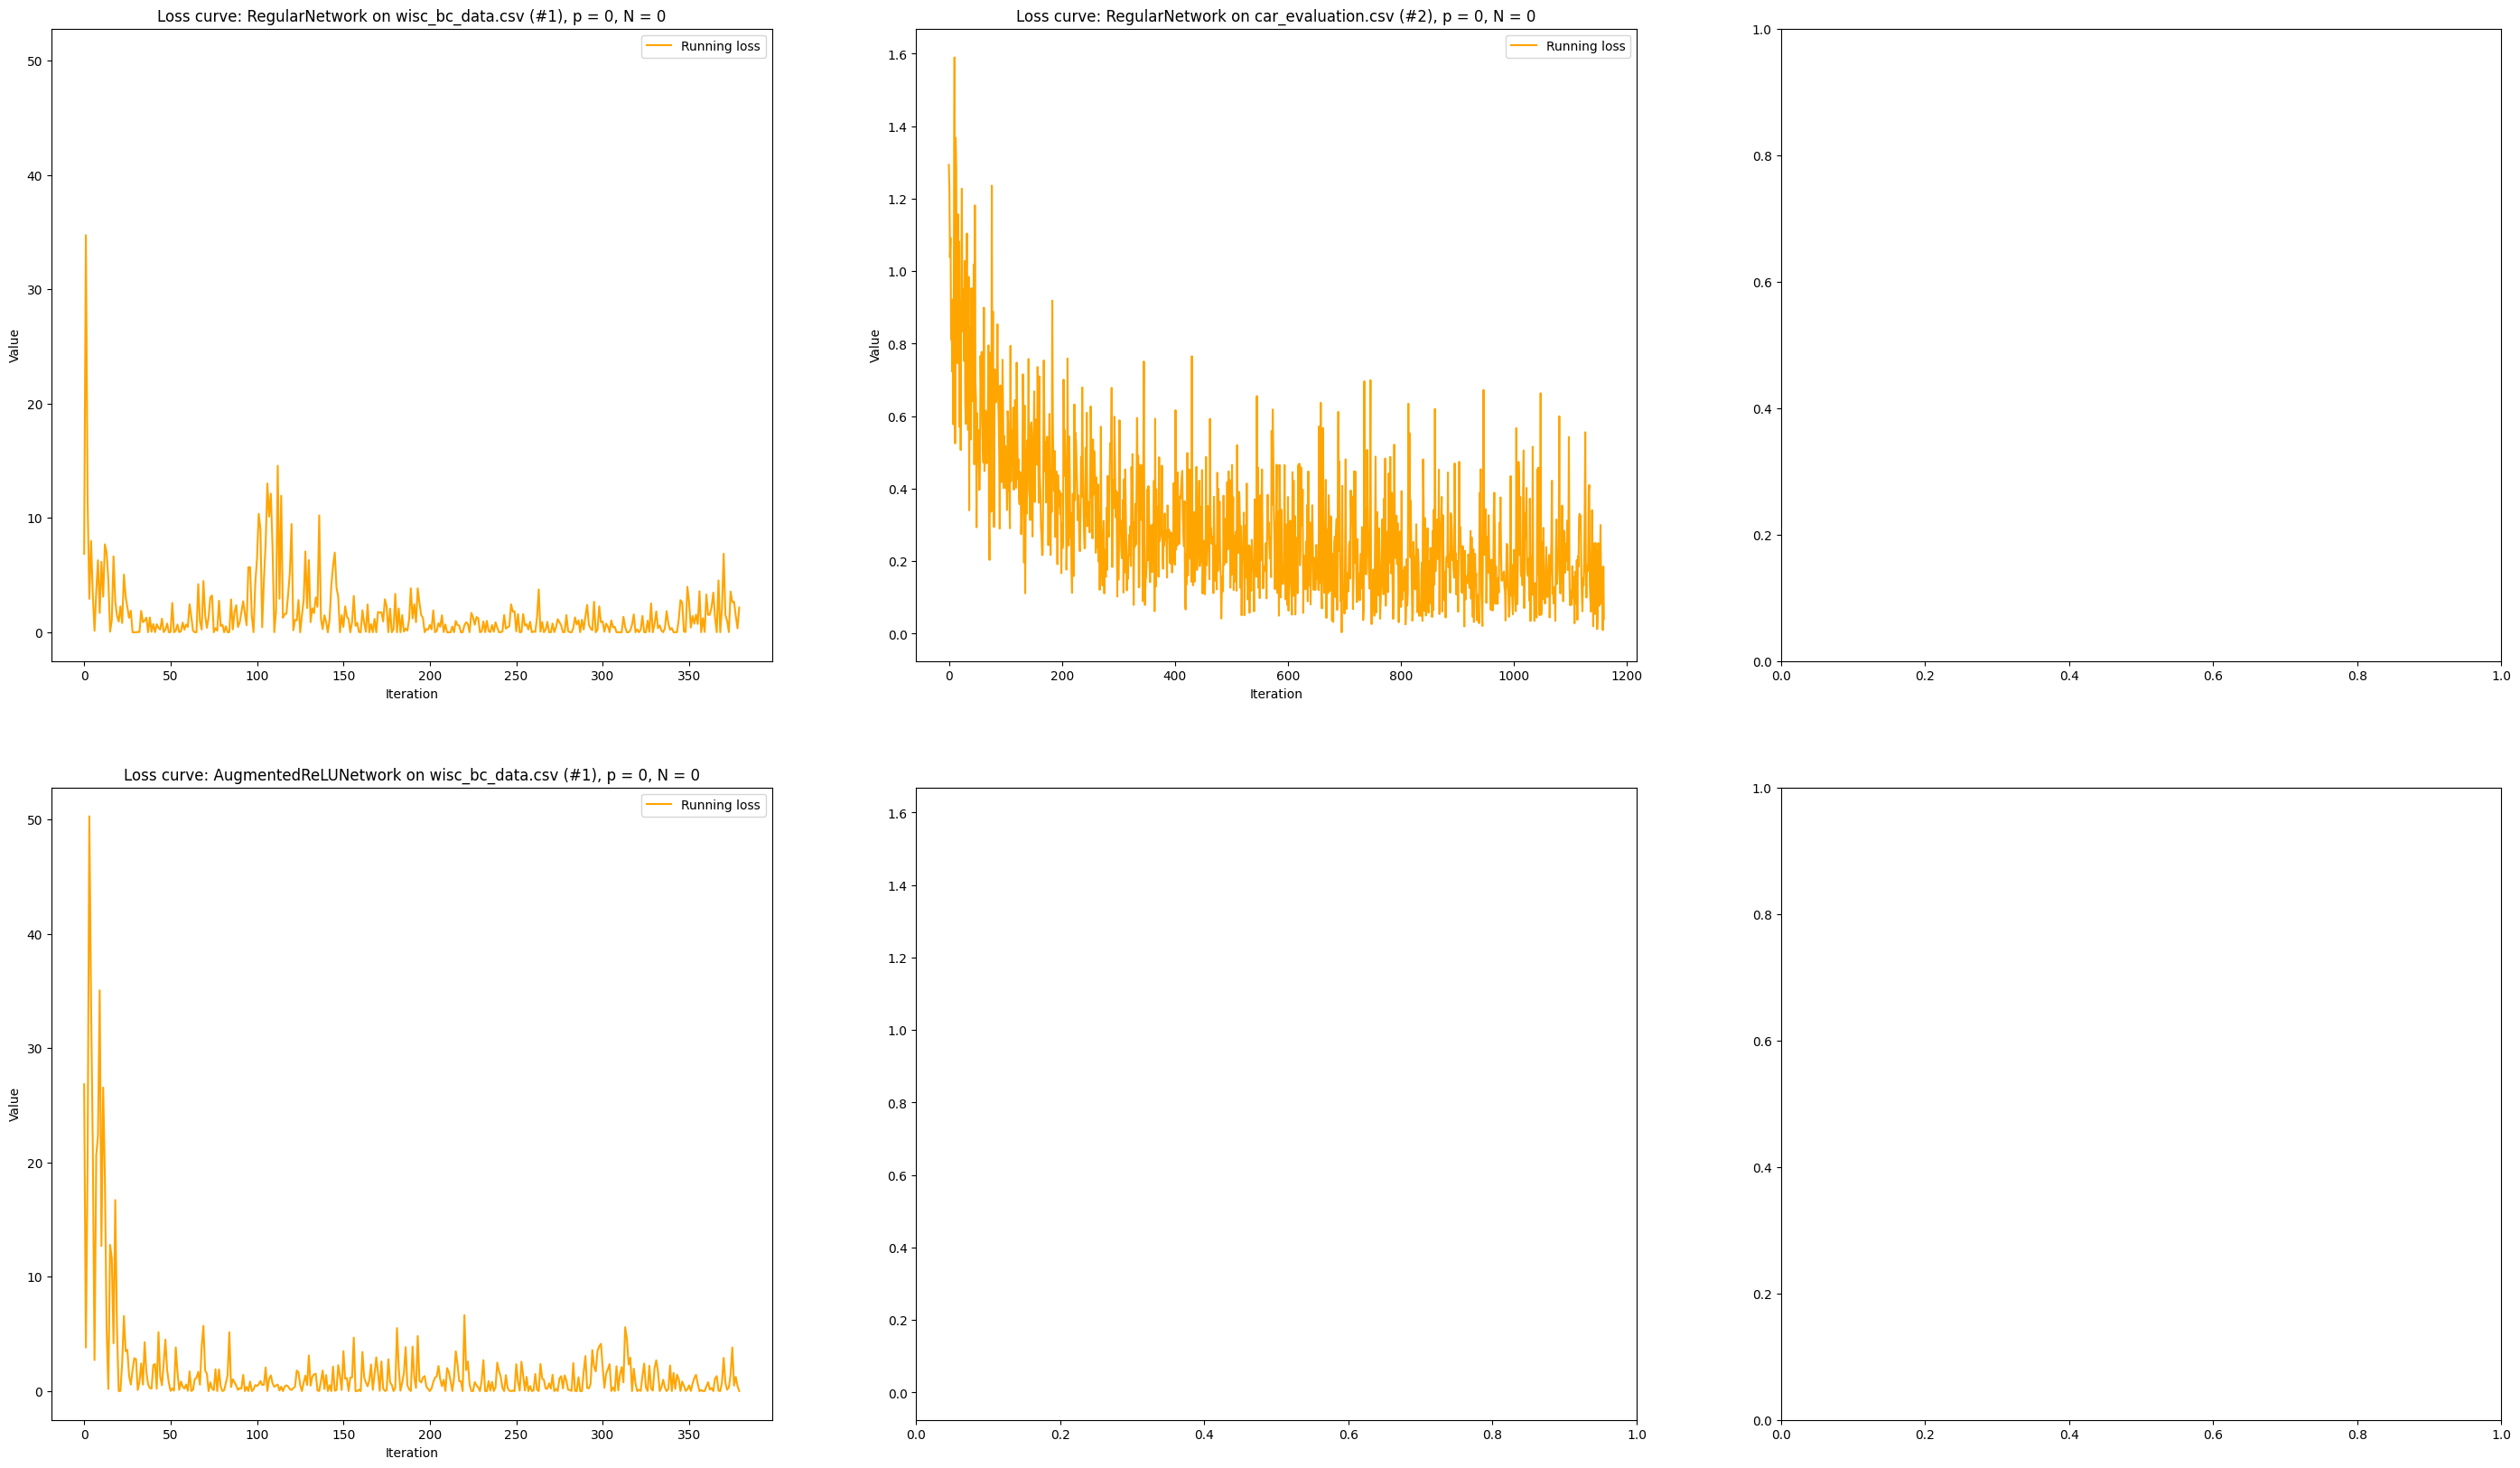

In [18]:
# 5.3. Training

from IPython.display import clear_output

for experiment_params in iterate_experiment_parameters():
    fig, axs = plt.subplots(2, 3, sharey='col', figsize=(10, 12))
    fig.set_size_inches(35, 20)

    for training_params in [
        TrainingParameters(
            dataset=DATASETS[0],
            criterion=CLASSIFICATION_TASK.criterion,
            experiment_params=experiment_params,
            model_a_path=DATASETS[0].model_a_path(experiment_params),
            model_b_path=DATASETS[0].model_b_path(experiment_params),
            loss_curve_plot_col_index=0,
        ),
        TrainingParameters(
            dataset=DATASETS[1],
            criterion=CLASSIFICATION_TASK.criterion,
            experiment_params=experiment_params,
            model_a_path=DATASETS[1].model_a_path(experiment_params),
            model_b_path=DATASETS[1].model_b_path(experiment_params),
            loss_curve_plot_col_index=1,
        ),
        TrainingParameters(
            dataset=DATASETS[2],
            criterion=REGRESSION_TASK.criterion,
            experiment_params=experiment_params, 
            model_a_path=DATASETS[2].model_a_path(experiment_params),
            model_b_path=DATASETS[2].model_b_path(experiment_params),
            loss_curve_plot_col_index=2,
        )
    ]:
        inputs_count = training_params.dataset.features_count
        outputs_count = training_params.dataset.classes_count

        for (model, name, row) in [
            (RegularNetwork(
                inputs_count=inputs_count,
                outputs_count=outputs_count,
                p=experiment_params.p
            ), training_params.model_a_path, 0),
            (AugmentedReLUNetwork(
                inputs_count=inputs_count,
                outputs_count=outputs_count,
                p=experiment_params.p
            ), training_params.model_b_path, 1)
        ]:
            model.apply(init_weights)
            
            model = model.to(device)
            
            running_losses = train(
                model=model,
                dataset=training_params.dataset,
                epochs=EPOCHS,
                experiment_parameters=experiment_params,
                criterion=training_params.criterion,
                optimizer=optim.Adam(
                    model.parameters(),
                    lr=LEARNING_RATE
                )
            )
            
            torch.save(model.state_dict(), name)
            
            report_key = f'loss_{type(model).__name__}_{training_params.dataset.number}_p{experiment_params.p}_N{experiment_params.iteration}'
            
            append_to_report(report_key, running_losses)
            
            col = training_params.loss_curve_plot_col_index

            plot_loss_curve(
                ax=axs[row, col],
                model_name=model.__class__.__name__,
                dataset_name=training_params.dataset.name,
                dataset_number=training_params.dataset.number,
                running_losses=running_losses,
                p=experiment_params.p,
                iteration=experiment_params.iteration
            )
    
    path = save_plot(f'loss__p{experiment_params.p}_N{experiment_params.iteration}')

print("Done!")

## 6. Валидация и анализ данных

In [ ]:
# 1. Загрузка отчёта

import json

with open('./report.json') as report:
    report = json.load(report)

In [ ]:
# 2. Составление индекса для поиска по отчёту

import pandas as pd

df = pd.DataFrame([[key] + key.split('_') for key in report.keys()])
df.columns = ['Key', 'Measurement', 'Network', 'Dataset', 'P', 'N']
df.Dataset = df.Dataset.apply(lambda x: int(x))
df.P = df.P.apply(lambda x: float(x[1:]))
df.N = df.N.apply(lambda x: int(x[1:]))
df

,Key,Measurement,Network,Dataset,P,N
0,loss_RegularNetwork_1_p0_N0,loss,RegularNetwork,1,0.00,0
1,loss_AugmentedReLUNetwork_1_p0_N0,loss,AugmentedReLUNetwork,1,0.00,0
2,loss_RegularNetwork_2_p0_N0,loss,RegularNetwork,2,0.00,0
3,loss_AugmentedReLUNetwork_2_p0_N0,loss,AugmentedReLUNetwork,2,0.00,0
4,loss_RegularNetwork_3_p0_N0,loss,RegularNetwork,3,0.00,0
...,...,...,...,...,...,...
835,evaluate_RegularNetwork_2_p0.99_N9,evaluate,RegularNetwork,2,0.99,9
836,evaluate_RegularNetwork_3_p0.99_N9,evaluate,RegularNetwork,3,0.99,9
837,evaluate_AugmentedReLUNetwork_1_p0.99_N9,evaluate,AugmentedReLUNetwork,1,0.99,9
838,evaluate_AugmentedReLUNetwork_2_p0.99_N9,evaluate,AugmentedReLUNetwork,2,0.99,9


In [ ]:
# 3. Вывод графиков

import os
from dataclasses import dataclass

import matplotlib.pyplot as plt

@dataclass
class PlotParams:
    measurement: str
    dataset: int
    network = 'AugmentedReLUNetwork'
    metric: str
    p: int
    
def compute_dataframe(plot_params: PlotParams) -> pd.DataFrame:
    rows = (
        df
            .loc[df.Measurement == plot_params.measurement]
            .loc[df.Dataset == plot_params.dataset]
            .loc[df.Network == plot_params.network]
            .loc[df.P == plot_params.p]
    )

    if plot_params.measurement == 'loss':
        values = pd.DataFrame([report[row.Key] for row in rows.itertuples()])
    else:
        cols = []
        
        for row in rows.itertuples():
            report_data = report[row.Key]
            cols.append(report_data[plot_params.metric])
            
        values = pd.DataFrame(cols)

    result = values.quantile([0.25, 0.75]).transpose()
    result['mean'] = values.mean()
    return result


def plot_curve(
    ax: object,
    means: pd.Series,
    lowerqs: pd.Series,
    upperqs: pd.Series,
    zmeans: pd.Series,
    zlowerqs: pd.Series,
    zupperqs: pd.Series,
    X: pd.Series,
    title: str,
    xlabel: str,
    ylabel: str,
):
    ax.plot(X, zmeans, label='Mean of p = 0', color='lightblue')
    ax.fill_between(X, zlowerqs, zupperqs, color='lightgray', alpha=0.5, label='0.25 to 0.75 Quantiles, p = 0')
    ax.plot(X, means, label='Mean', color='blue')
    ax.fill_between(X, lowerqs, upperqs, color='gray', alpha=0.5, label='0.25 to 0.75 Quantiles')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()


for (measurement, dataset, xlabel) in [
    ('loss', 1, 'iteration'),
    ('evaluate', 1, 'noise factor'),
    ('loss',  2, 'iteration'),
    ('evaluate', 2, 'noise factor'),
    ('loss', 3, 'iteration'),
    ('evaluate', 3, 'noise factor'),
]:
    if measurement == 'loss':
        metrics = ['loss']
    else:
        if dataset == 3:
            metrics = ['r2', 'mse']
        else:
            metrics = ['f1', 'accuracy', 'roc_auc']
    
    fig, axs = plt.subplots(len(metrics), 6, figsize=(24, len(metrics) * 6))
    for (i, metric) in enumerate(metrics):
        reference_curve = compute_dataframe(plot_params=PlotParams(
            measurement=measurement,
            dataset=dataset,
            metric=metric,
            p=0,
        ))

        for (j, p) in enumerate([0.01, 0.05, 0.5, 0.9, 0.95, 0.99]):
            plot_params=PlotParams(
                measurement=measurement,
                dataset=dataset,
                metric=metric,
                p=p,
            )

            curve=compute_dataframe(plot_params=plot_params)
            plot_curve(
                ax=axs[i, j] if len(metrics) > 1 else axs[j],
                means=curve['mean'],
                lowerqs=curve[0.25],
                upperqs=curve[0.75],
                zmeans=reference_curve['mean'],
                zlowerqs=reference_curve[0.25],
                zupperqs=reference_curve[0.75],
                X=curve.index,
                title=f'p = {plot_params.p}',
                xlabel=xlabel,
                ylabel=metric,
            )
    fig.suptitle(f'Dataset #{plot_params.dataset}')
    plt.tight_layout()
    path = os.path.join('report/', f'{measurement}_{dataset}.png')
    plt.savefig(path)
    plt.close()